# 4 Modelling Report

## 4.1 Select Modelling Technique

In this section we will select the data mining techniques that will be applied to this problem. As we want to investigate the structure of this data we will use unsupervised learning techniques. Specifically clustering techniques like k-means, x-means and DBScan. 

### 4.1.1

## 4.2 Generate Test Design

In the first instance we will take one week of data that is complete i.e. a record exists for every 15 minute interval during that week. 

### 4.2.1 Creating an limited test dataset

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [36]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = '../data/saville_row_east_west/'
OUTPUT_TABLES_PATH = '../output/tables/4/'
OUTPUT_FIGURES_PATH = '../output/figures/4/'

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap
custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, 'east_df.pkl'))
west_df = pd.read_pickle(os.path.join(DATA_PATH, 'west_df.pkl'))

west_complete_days_df = pd.read_pickle(os.path.join(DATA_PATH, 'west_complete_days_df.pkl'))

In [37]:
week_number = 2
year = 2023
df_selected_week = west_df[(west_df['date'].dt.isocalendar().week == week_number) & (west_df['date'].dt.year == year)]

We need to find a week were there are ideally complete entries. To calculate the number of entries expected in a full week we use the following formula:

4 (number of 15 minute periods in an hour) x 24 (hours in the day) x 7 (days in the week) x 2 (directions of walking along the street)

In [38]:
4*24*7*2 == len(df_selected_week)

True

In [39]:
# combine the data from each sensor direction
data_aggregated = df_selected_week.groupby('dt').agg({'value':'sum'})
print(f"Length of data for selected week: {len(df_selected_week)}"), print(f"Length of data aggregated on time stamp: {len(data_aggregated)}")

# statistical feature extraction and resampling
data_resampled = pd.DataFrame()
data_resampled['sum'] = data_aggregated.resample('h').sum()
data_resampled['mean'] = data_aggregated.resample('h').mean()
data_resampled['std'] = data_aggregated.resample('h').std()

print(f"Length of data resampled hourly: {len(data_resampled)}")

Length of data for selected week: 1344
Length of data aggregated on time stamp: 672
Length of data resampled hourly: 168


### 4.2.2 Clustering the data at hourly aggregations

We first need to rescale our dataset to improve convergence.

The `sklearn.preprocessing.StandardScaler` is calculated using z = (x - u) / s

In [40]:
# X = data_resampled['mean']
X = data_resampled

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

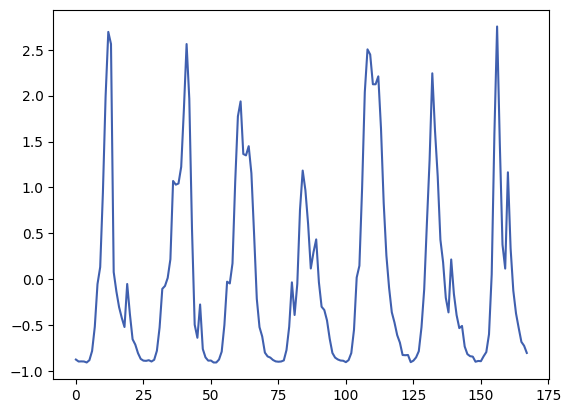

In [41]:
plt.plot(X[:,0])

In [42]:
from sklearn.cluster import KMeans

N_CLUSTERS = 2

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)

labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

print(f"Labels: {labels}"), print(f"Centroids: {centroids}")

Labels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0]
Centroids: [[-0.50069243 -0.50069243 -0.33725279]
 [ 1.55092534  1.55092534  1.04466108]]


c:\#code\#python\#current\mres-project\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(None, None)

In [43]:
print(len(data_resampled.index))
print(len(X))
print(len(labels))

168
168
168


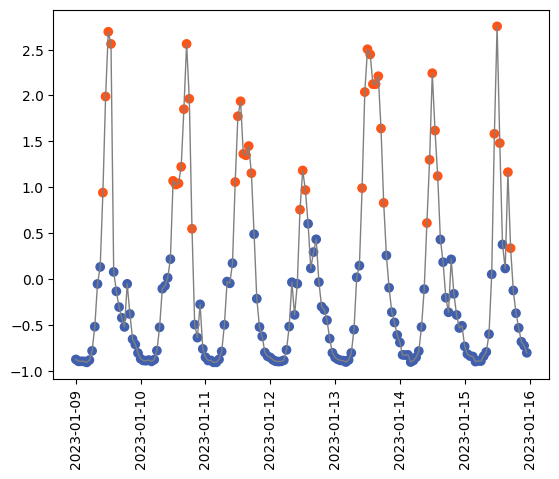

In [44]:
from matplotlib.colors import ListedColormap

# Convert labels to colors using the colormap
cmap = ListedColormap(custom_palette[:N_CLUSTERS])
label_colors = cmap(labels)

# Create the scatter plot
plt.scatter(data_resampled.index, X[:,0], color=label_colors)
plt.plot(data_resampled.index, X[:,0], c='gray', linewidth=1)
plt.xticks(rotation=90)
plt.show()

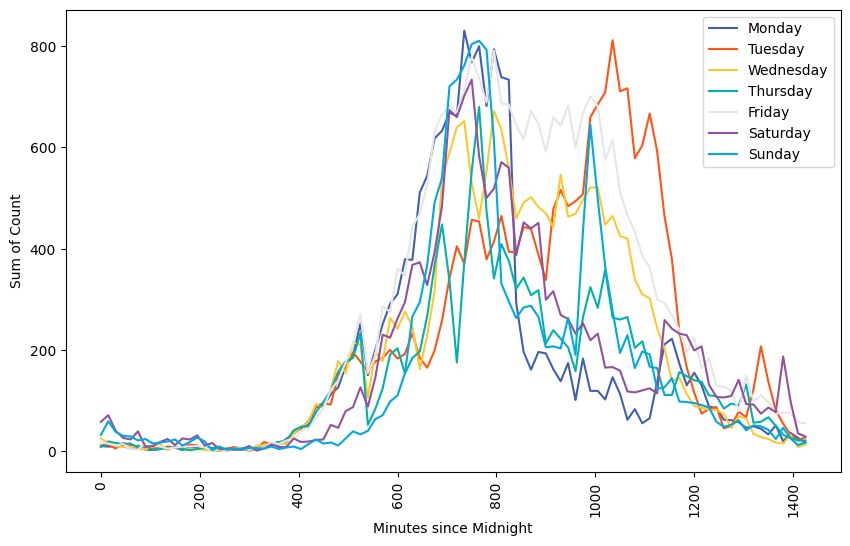

In [45]:
df = df_selected_week.groupby('dt').agg({'minutes_since_midnight':'first', 'value':'sum', 'day_in_week':'first'})

# Create a colormap with as many colors as there are weekdays
custom_palette = get_custom_palette()
cmap = ListedColormap(custom_palette[:7])

# Define weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))

# Create a scatter plot for each weekday
for i, day in enumerate(weekdays):
    df_day = df[df['day_in_week'] == i]
    plt.plot(df_day['minutes_since_midnight'], df_day['value'], color=cmap(i), label=day)

plt.xticks(rotation=90)
plt.xlabel("Minutes since Midnight")
plt.ylabel("Sum of Count")
plt.legend()
plt.show()

### 4.2.3 Clustering the data at daily aggregations

As we are missing some of the data, aggregations at the daily level will use the mean count rather than the sum count as we have used previously. Additionally, only days where there is greater than 90% data completeness will be used. 

In [46]:
west_complete_days_df.head(2)

,dt,value,veh_class,dir,location,category,key,date,time,year-month-day-hour,...,month-hour,hours_since_midnight,minutes_since_midnight,month,quarter,year-month,year-week,year-quarter,day_of_week,day_in_week
297,2021-12-03,48,person,northwest_to_southwest,NclNorthumberlandStSavilleRowWest,flow,2021-12,2021-12-03,00:00:00,2021-12-03 00,...,12 00,0,0,12,4,2021-12,2021-48,2021-4,Friday,4
299,2021-12-03,11,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2021-12,2021-12-03,00:00:00,2021-12-03 00,...,12 00,0,0,12,4,2021-12,2021-48,2021-4,Friday,4


#### 4.2.3.1 Model 0 (Baseline)

For our first clustering model we will use `sklearn.cluster.KMeans`. The steps for creating this model are:
1. Prepare the data.
    * Aggregate the pedestrian flow for both trajectories yielding sum.
    * Resample the data on each day yielding mean and std.
    * Scale the data using `sklearn.preprocessing.StandardScalar` (z = x - u / s)
2. Model the data
    * Use k=4 as an initial cluster value (representing seasonal periodicity)
    * Plot the results

In [47]:
from eda_helper import aggregate_and_preprocess_daily_data
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

c:\#code\#python\#current\mres-project\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Labels: [3 3 2 1 1 3 3 3 3 3 1 3 1 1 3 1 3 1 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 2 2 2
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 2 2 2 2 1 0 1 0 0 0 1 1 1
 3 0 0 1 0 0 1 0 2 0 3 0 1 0 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 0 2 0 1 1 1 0 0 1 0 2 0 0 0 2 0 0 0 0 0 2 0 2 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 2 0 0 0 0 2 0 2 2 1 0 0 0 0 0 0 0 0 2 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 2 0 0 0 3 0 1 1 3 3 3 3 1 1 1 0 3 3 3 1 1 1 3 3 3 3 1 1 1 1 3 1 1 1 3
 3 3 3 3 1 1 1 3 3 3 3 3 3 3 2 3 3 3 1 1 2 1 1 1 0 0 1 0 0 0 0 0 1 0 0 2 0
 1 0 1 3 0 1 1 1 0 1 3 0 1 1 1 1 1 3 0 1 0 1 1 1 3 1 0 1 1 1 1 3 0 1 3 1 3
 3 3 0 1 1 1 1 1 3 0 1 1 2 1 1 3 1 1 1 3 1 1 0 1 1 1 1 1 3 0 0 0 1 1 1]
Centroids: [[-0.34302175 -0.3277217 ]
 [ 0.58554539  0.52833803]
 [-1.30405767 -1.28778787]
 [ 1.64972028  1.700969  ]]


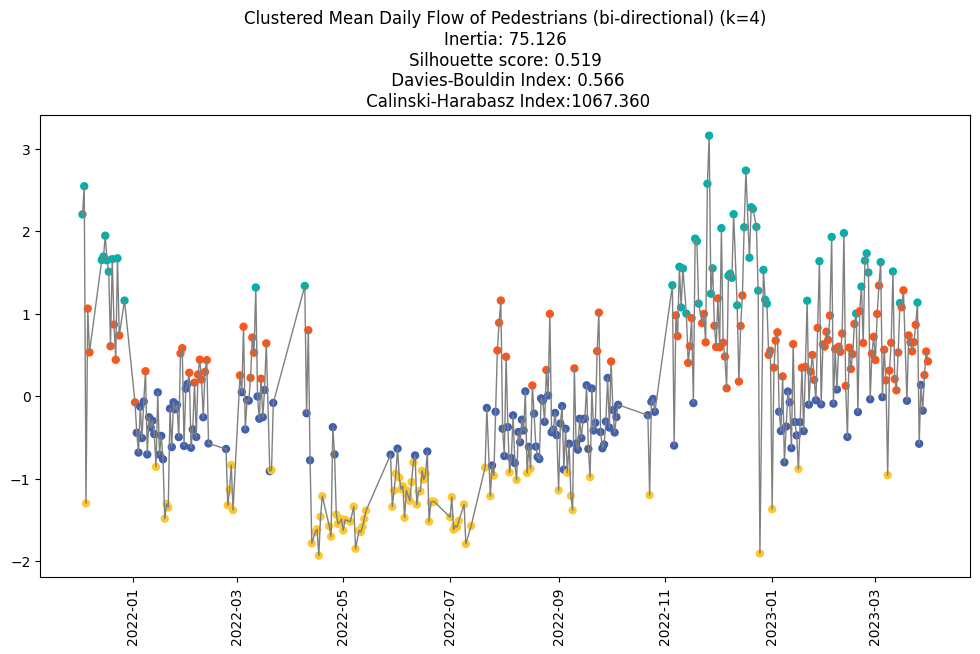

In [48]:
N_CLUSTERS = 4

X, X_index, X_columns = aggregate_and_preprocess_daily_data(west_complete_days_df)

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)

labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

print(f"Labels: {labels}"), print(f"Centroids: {centroids}")

from matplotlib.colors import ListedColormap

# convert labels to colors using the colormap
cmap = ListedColormap(custom_palette[:N_CLUSTERS])
label_colors = cmap(labels)
centroid_colors = cmap(centroids[1])

# create the scatter plot
plt.figure(figsize=(12,6))
# plt.scatter(centroids[0], centroids[1], c=centroid_colors)
plt.plot(X_index, X[:,0], c='gray', linewidth=1)
plt.scatter(X_index, X[:,0], c=label_colors, s=25)
plt.xticks(rotation=90)
plt.title(f"Clustered Mean Daily Flow of Pedestrians (bi-directional) (k=4)\nInertia: {kmeans.inertia_:.3f}\nSilhouette score: {silhouette_score(X, labels):.3f}\n Davies-Bouldin Index: {davies_bouldin_score(X, labels):.3f}\n Calinski-Harabasz Index:{calinski_harabasz_score(X, labels):.3f}")
plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Clustering daily mean flow of pedestrians.svg'), bbox_inches='tight', dpi=200)
plt.show()

###

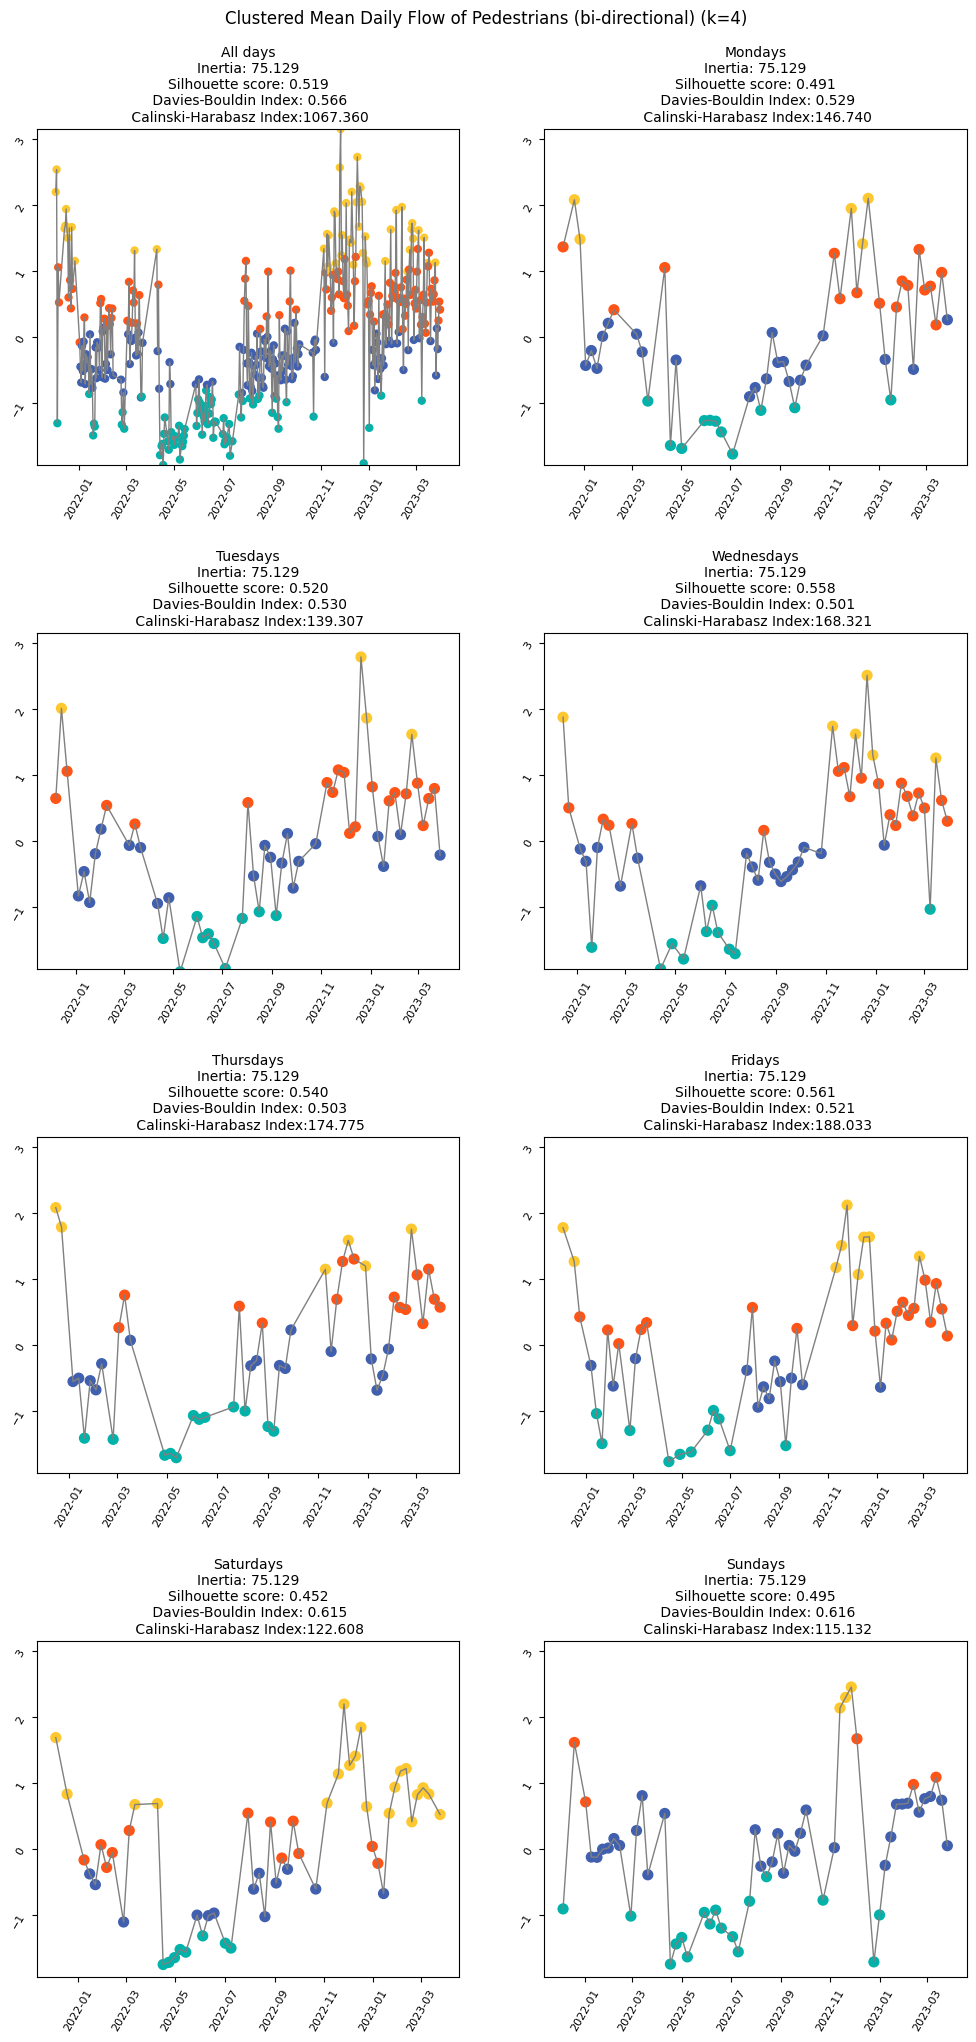

In [49]:
import calendar

N_CLUSTERS = 4

fig, ax = plt.subplots(4,2, figsize=(12,24))
fig.suptitle("Clustered Mean Daily Flow of Pedestrians (bi-directional) (k=4)", y=0.93)
fig.subplots_adjust(hspace=0.5)

# list weekday names
days_of_week = list(calendar.day_name)

# perform k-means clustering on the entire data
all_X, all_X_index, all_X_columns = aggregate_and_preprocess_daily_data(west_complete_days_df)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10)
kmeans.fit(all_X)
all_labels = kmeans.predict(all_X)
all_centroids = kmeans.cluster_centers_

# determine the overall min and max y-values across all the data
y_min = np.min(all_X[:, 0])
y_max = np.max(all_X[:, 0])

# set the cluster colors
cmap = ListedColormap(custom_palette[:N_CLUSTERS])
all_label_colors = cmap(all_labels)

# plot all days first at ax[0,0]
ax[0, 0].plot(all_X_index, all_X[:,0], c='gray', linewidth=1)
ax[0, 0].scatter(all_X_index, all_X[:,0], c=all_label_colors, s=25)
ax[0, 0].set_title(f"All days\nInertia: {kmeans.inertia_:.3f}\nSilhouette score: {silhouette_score(X, labels):.3f}\n Davies-Bouldin Index: {davies_bouldin_score(X, labels):.3f}\n Calinski-Harabasz Index:{calinski_harabasz_score(X, labels):.3f}", fontsize=10)
ax[0, 0].tick_params(labelrotation=60, labelsize=8)
ax[0, 0].set_ylim(y_min, y_max)  # set consistent y-limits

# start plotting the rest of the days starting from ax[0,1]
for i in range(7): 
    df = west_complete_days_df[west_complete_days_df['day_in_week'] == i % 7]
    X, X_index, X_columns = aggregate_and_preprocess_daily_data(df)

    # use labels from the entire data for consistency
    labels = all_labels[all_X_index.isin(X_index)]
    label_colors = all_label_colors[all_X_index.isin(X_index)]
    
    ax[(i+1) // 2, (i+1) % 2].plot(X_index, X[:,0], c='gray', linewidth=1)
    ax[(i+1) // 2, (i+1) % 2].scatter(X_index, X[:,0], c=label_colors, s=50)
    ax[(i+1) // 2, (i+1) % 2].set_title(f"{days_of_week[i % 7]}s\nInertia: {kmeans.inertia_:.3f}\nSilhouette score: {silhouette_score(X, labels):.3f}\n Davies-Bouldin Index: {davies_bouldin_score(X, labels):.3f}\n Calinski-Harabasz Index:{calinski_harabasz_score(X, labels):.3f}", fontsize=10)
    ax[(i+1) // 2, (i+1) % 2].tick_params(labelrotation=60, labelsize=8)
    ax[(i+1) // 2, (i+1) % 2].set_ylim(y_min, y_max)  # set consistent y-limits

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Clustering daily mean flow of pedestrians (by day).svg'), bbox_inches='tight', dpi=200)

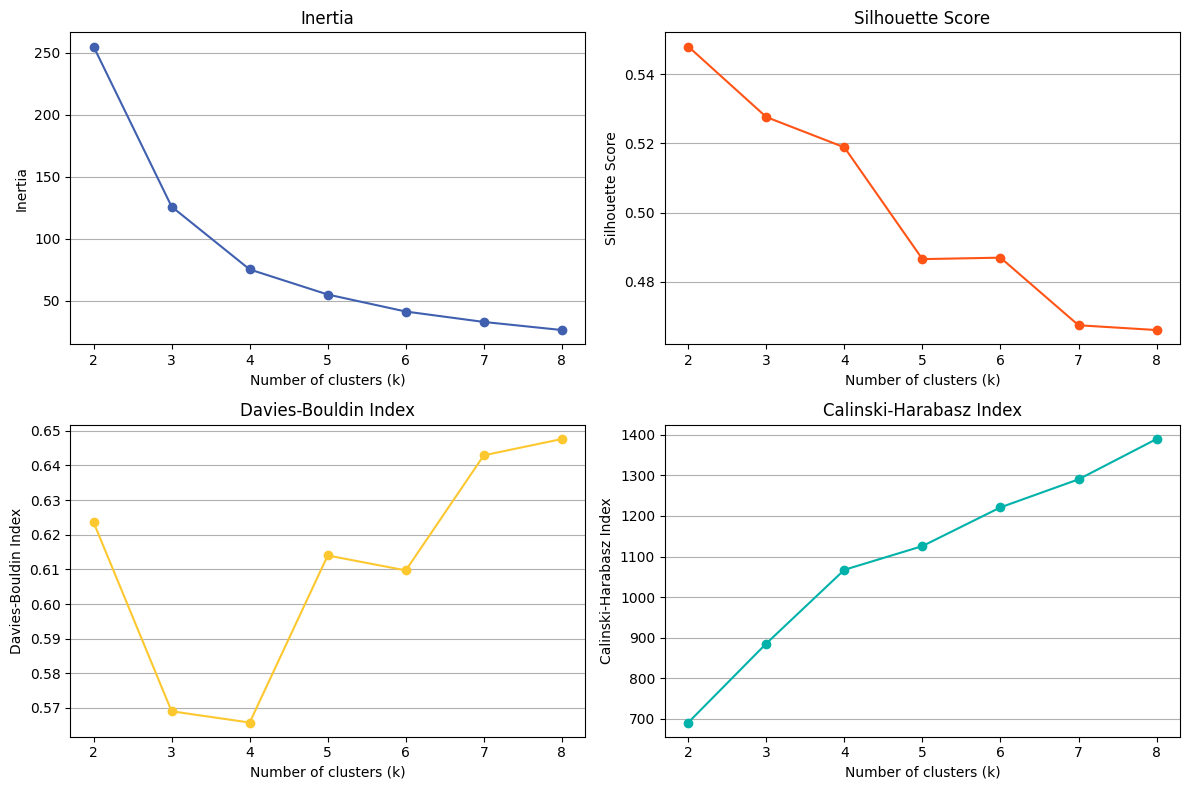

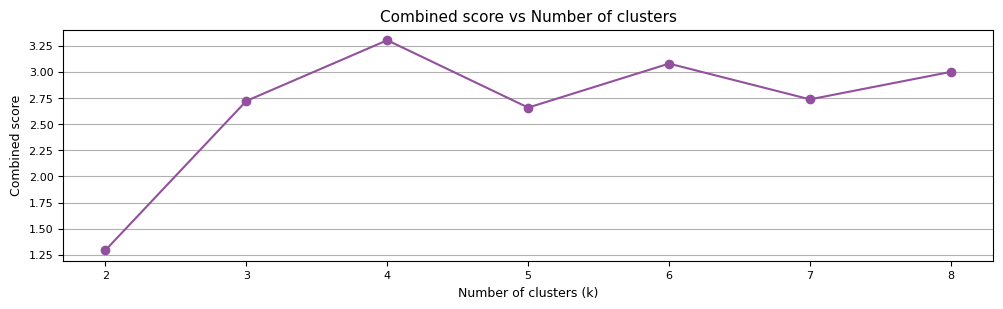

In [53]:
# perform k-means clustering on the entire data
all_X, all_X_index, all_X_columns = aggregate_and_preprocess_daily_data(west_complete_days_df)

results = []
k_values = range(2, 9)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(all_X)
    labels = kmeans.predict(all_X)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(all_X, labels)
    dbi = davies_bouldin_score(all_X, labels)
    chi = calinski_harabasz_score(all_X, labels)

    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'dbi': dbi,
        'chi': chi
    })

# convert results to DataFrame
df_results = pd.DataFrame(results)

# plot the four indices
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(df_results['k'], df_results['inertia'], marker='o', c=custom_palette[0])
axs[0, 0].set_title('Inertia')
axs[0, 0].set_xlabel('Number of clusters (k)')
axs[0, 0].set_ylabel('Inertia')
axs[0, 0].grid(True, which='major', axis='y')

axs[0, 1].plot(df_results['k'], df_results['silhouette'], marker='o', c=custom_palette[1])
axs[0, 1].set_title('Silhouette Score')
axs[0, 1].set_xlabel('Number of clusters (k)')
axs[0, 1].set_ylabel('Silhouette Score')
axs[0, 1].grid(True, which='major', axis='y')

axs[1, 0].plot(df_results['k'], df_results['dbi'], marker='o', c=custom_palette[2])
axs[1, 0].set_title('Davies-Bouldin Index')
axs[1, 0].set_xlabel('Number of clusters (k)')
axs[1, 0].set_ylabel('Davies-Bouldin Index')
axs[1, 0].grid(True, which='major', axis='y')

axs[1, 1].plot(df_results['k'], df_results['chi'], marker='o', c=custom_palette[3])
axs[1, 1].set_title('Calinski-Harabasz Index')
axs[1, 1].set_xlabel('Number of clusters (k)')
axs[1, 1].set_ylabel('Calinski-Harabasz Index')
axs[1, 1].grid(True, which='major', axis='y')

fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Clustering scores.svg'), bbox_inches='tight', dpi=200)
plt.show()

# show combined plots
from sklearn.preprocessing import MinMaxScaler
# initialize the MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_results), 
                             columns=df_results.columns, 
                             index=df_results.index)

# we have to maximize silhouette and calinski_harabasz, 
# and minimize inertia and davies_bouldin for our clustering to be good.
# therefore, we subtract inertia and davies_bouldin from 1 after normalization.
df_normalized['inertia'] = 1 - df_normalized['inertia']
df_normalized['dbi'] = 1 - df_normalized['dbi']

# sum the normalized scores across each row (i.e., for each cluster size)
df_normalized['combined'] = df_normalized.sum(axis=1)

# plot the combined score for each number of clusters
plt.figure(figsize=(12, 3))
plt.plot(df_results.index + 2, df_normalized['combined'], marker='o', c=custom_palette[5])
plt.xlabel('Number of clusters (k)', fontsize=9)
plt.ylabel('Combined score', fontsize=9)
plt.title('Combined score vs Number of clusters', fontsize=11)
plt.grid(True, which='major', axis='y')
plt.tick_params(labelsize=8)
plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Combined clustering score (normalised and unweighted).svg'), bbox_inches='tight', dpi=200)
plt.show()

(0.0, 1.0, 0.0, 1.0)

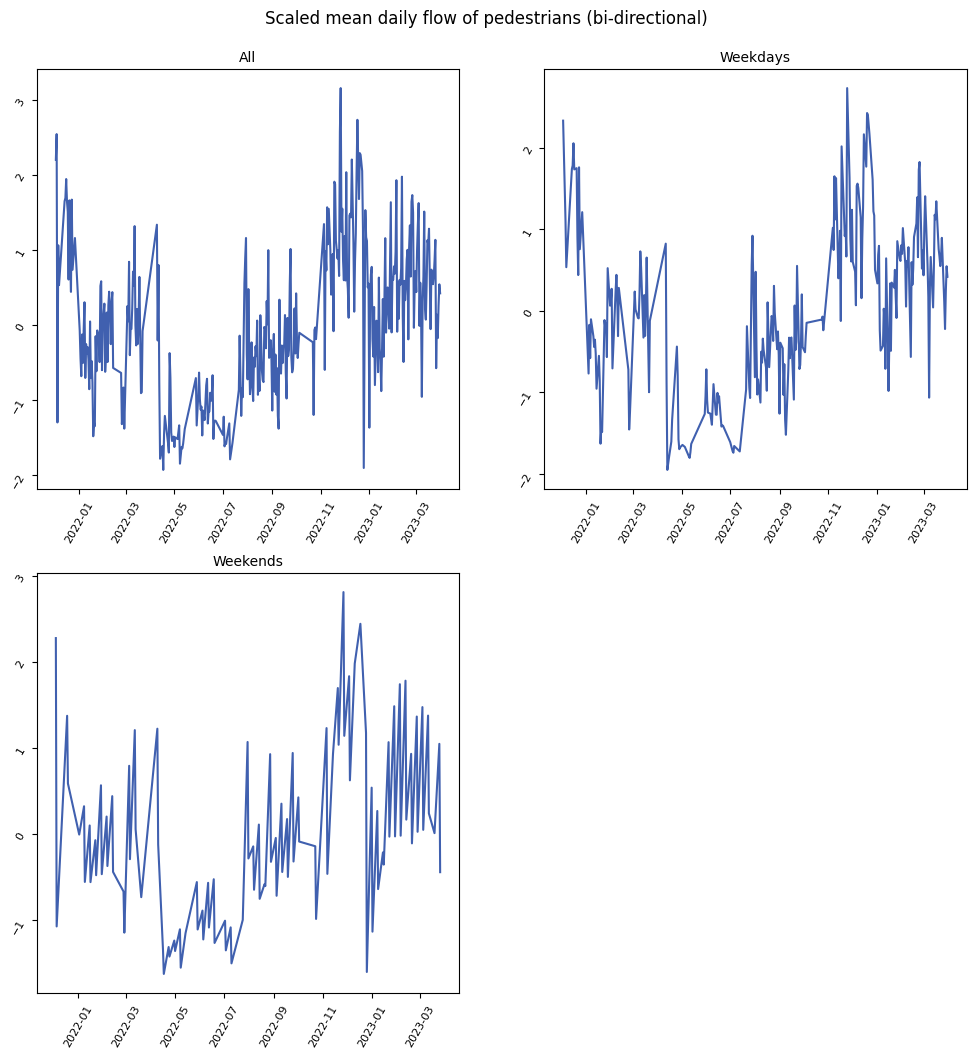

In [51]:
# pull out weekdays and weekends and each day of the week

# create a mask for weekdays (monday-friday)
weekday_mask = (west_complete_days_df['dt'].dt.weekday < 5)

# create seperate dataframes for weekdays and weekends
weekday_west_df = west_complete_days_df[weekday_mask]
weekend_west_df = west_complete_days_df[-weekday_mask]

from eda_helper import aggregate_and_preprocess_daily_data

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

X, X_index, X_columns = aggregate_and_preprocess_daily_data(west_complete_days_df)
ax[0,0].plot(X_index, X[:,0])
ax[0,0].set_title("All", fontsize=10)
ax[0,0].tick_params(labelrotation=60, labelsize=8)

X, X_index, X_columns = aggregate_and_preprocess_daily_data(weekday_west_df)
ax[0,1].plot(X_index, X[:,0])
ax[0,1].set_title("Weekdays", fontsize=10)
ax[0,1].tick_params(labelrotation=60, labelsize=8)

X, X_index, X_columns = aggregate_and_preprocess_daily_data(weekend_west_df)
ax[1,0].plot(X_index, X[:,0])
ax[1,0].set_title("Weekends", fontsize=10)
ax[1,0].tick_params(labelrotation=60, labelsize=8)

fig.suptitle(f"Scaled mean daily flow of pedestrians (bi-directional)", y=0.93)

ax[1,1].axis('off')

Labels: [5 5 1 2 3 2 2 2 2 2 3 2 3 3 2 2 2 0 0 4 0 4 0 3 4 0 4 4 4 4 0 4 4 4 1 1 1
 0 4 0 0 0 4 3 3 4 0 0 0 4 4 0 4 0 3 3 4 0 3 4 4 1 1 4 1 0 0 3 4 0 0 0 3 3
 2 0 0 0 4 0 3 4 4 0 2 0 3 4 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 4 1 1 1 4 1 1 1 1 1 1 1 1 4 4 1 1 1 4 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4
 0 1 4 1 0 3 3 2 0 4 3 4 1 4 0 4 1 4 4 4 4 0 4 4 4 0 0 4 4 4 0 0 4 0 0 2 4
 4 4 4 1 4 0 4 4 4 4 1 1 3 4 4 4 4 4 4 0 4 1 0 4 4 3 3 4 4 4 4 0 4 0 0 4 4
 0 0 1 0 0 0 2 4 3 3 2 2 2 2 3 3 3 0 2 2 2 3 3 3 5 5 2 2 3 3 2 3 5 3 3 0 2
 2 2 5 2 0 3 2 5 5 2 5 5 5 2 1 5 2 2 3 3 1 3 3 3 0 4 3 4 0 0 0 4 3 4 0 4 0
 0 4 3 2 0 0 3 0 0 3 2 0 3 3 3 3 3 2 0 3 0 3 3 3 2 0 4 3 3 3 3 2 0 2 2 3 2
 2 2 0 3 3 3 3 2 2 0 3 0 1 0 3 2 0 0 3 2 3 2 0 3 3 3 3 3 2 4 0 4 0 3 3]
Centroids: [[-0.0068929   0.02129247]
 [-1.36461158 -1.34164224]
 [ 1.39599127  1.40635914]
 [ 0.63187585  0.57012782]
 [-0.56635477 -0.57717474]
 [ 2.30294523  2.40232277]]


c:\#code\#python\#current\mres-project\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


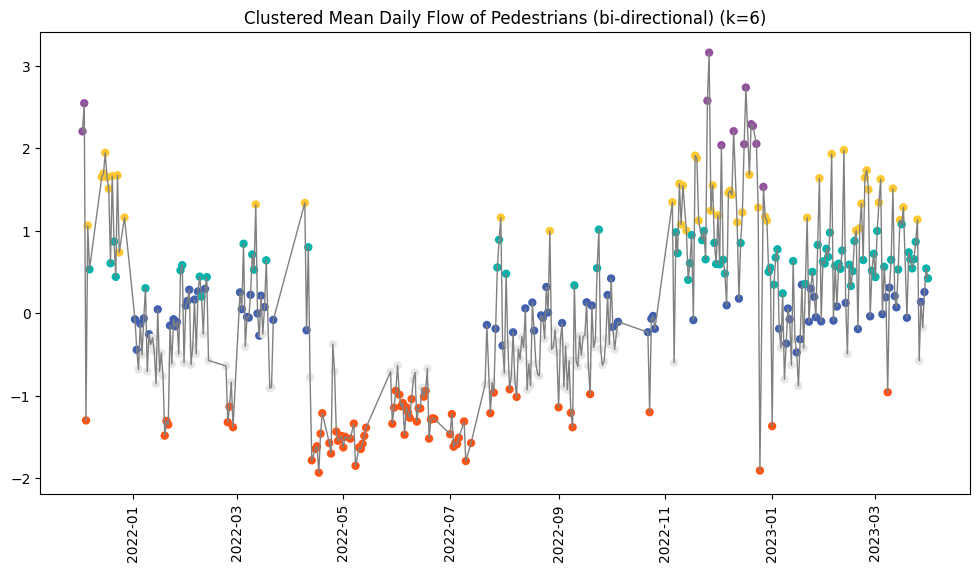

In [52]:
from sklearn.cluster import KMeans

X, X_index, X_columns = aggregate_and_preprocess_daily_data(west_complete_days_df)

N_CLUSTERS = 6

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)

labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

print(f"Labels: {labels}"), print(f"Centroids: {centroids}")

from matplotlib.colors import ListedColormap

# convert labels to colors using the colormap
cmap = ListedColormap(custom_palette[:N_CLUSTERS])
label_colors = cmap(labels)
centroid_colors = cmap(centroids[1])

# create the scatter plot
plt.figure(figsize=(12,6))
# plt.scatter(centroids[0], centroids[1], c=centroid_colors)
plt.plot(X_index, X[:,0], c='gray', linewidth=1)
plt.scatter(X_index, X[:,0], c=label_colors, s=25)
plt.xticks(rotation=90)
plt.title(f"Clustered Mean Daily Flow of Pedestrians (bi-directional) (k={N_CLUSTERS})")
plt.show()

## 4.3 Build Model

## 4.4 Assess Model